#  LMS Exploration | 2019 2nd ML month with KaKR

#### 프로젝트 루브릭


* 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission 까지의 전과정
* 전처리, 학습, 최적화 진행 과정이 체계적으로 기술
* 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수 얻기

#### 시도해볼 수 있는 방법
* 피처 엔지니어링
* LGBMRegressor, XGBRegressor, RandomForestRegressor 세 가지 이상의 다양한 모델에 대해 하이퍼 파라미터 튜닝
* 다양한 하이퍼 파라미터에 대해 그리드 탐색을 시도해서 최적의 조합 찾기
* 블렌딩 기법 활용하기 (오늘 다루지 않은 스태킹 앙상블 기법도 있음)
* 등등

#### 제출방법
* 결과 csv는 캐글에 제출
* 사용한 노트북은 깃허브(GitHub)를 통해 lms 제출. 노트북에 캐글 Submission 스코어 기재하기!

# 0. Preparation

### Load Pakages 

In [1]:
import os
from os.path import join

import pandas as pd #- Analysis
import numpy as np

import matplotlib.pyplot as plt #- Visualization
import seaborn as sns

import missingno as msno
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb


from scipy.stats import norm #Analysis 
from sklearn.preprocessing import StandardScaler #Analysis 
from scipy import stats #Analysis 

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import gc #- Garbage Collection

### Load dataset

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')  

print(train_data_path)
print(test_data_path)

data = pd.read_csv(train_data_path) #- train dataset
train = data.copy()
test = pd.read_csv(test_data_path) #- test dataset

/aiffel/aiffel/kaggle_kakr_housing/data/train.csv
/aiffel/aiffel/kaggle_kakr_housing/data/test.csv


In [3]:
print('train data dim : {}'.format(data.shape))
print('test data dim : {}'.format(test.shape))

train data dim : (15035, 21)
test data dim : (6468, 20)


* 훈련과 평가 데이터의 크기는 대략 15000와 6500으로 적은 편이고, 비율은 5:2 이다..
* 변수의 개수가 20개로 적은 편이어서 적절한 feature를 만들어내는 것이 모델 성능에 큰 영향을 미칠 것이다.
* 훈련 데이터의 경우 우리가 예측해야 하는 값인 price 데이터가 포함되어 있어 21개의 변수를 보유하고 있다. 

### 학습 데이터와 테스트 데이터 합치기
* 전체 데이터를 탐색하고 전처리를 진행하기 위해 학습데이터와 테스트 데이터를 합친다.
* 이후 train dataset을 분리할 수 있는 인덱스를 기억해두자.

In [4]:
train_len = len(data) #- 이후 학습 데이터를 불러올 수 있는 인덱스
print(train_len)
data = pd.concat((data, test), axis=0)

print(len(data))

15035
21503


In [5]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


# 1. 데이터 탐색 | EDA

* 문제 정의
* 변수 설명
* 시각화
* 이상치 및 결측치 확인

## 1.1 문제정의
* 집의 가격은 주거 공간의 목적, 위치, 경관, 건물의 연식 등 여러가지 복잡한 요인의 조합에 의해 결정된다.
* 이번 데이터의 목적은 어떤 조건을 가진 집의 가격이 높고 낮은지를 예측하는 모델을 만드는 것이다.
* 즉 **집의 정보를 가지고 가격을 예측하는 회귀문제**이다. 
* 평가에는 Root Mean Squared Error(RMSE) 를 사용한다. 
$${\sqrt{ {1 \over N} \sum{(yt - y{pr})}^2}} $$
* 이 데이터셋은 2014년 5월부터 2015년 5월까지 매매된 King Country의 집값 데이터를 포함하고 있다.

## 1.2 변수 설명


1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)


### 유니크한 갯수
각 변수를 이해하기 위해, 변수에서 유니크(unique)한 값의 개수를 알아본다.

In [6]:
print(data.shape)

(21503, 21)


In [7]:
print(data.nunique())

id               21503
date               372
price             3263
bedrooms            13
bathrooms           30
sqft_living       1038
sqft_lot          9782
floors               6
waterfront           2
view                 5
condition            5
grade               12
sqft_above         946
sqft_basement      306
yr_built           116
yr_renovated        70
zipcode             70
lat               5034
long               752
sqft_living15      777
sqft_lot15        8689
dtype: int64


In [8]:
data['floors'].unique()

array([1. , 2. , 1.5, 3. , 2.5, 3.5])

* DataFrame.nunique(axis=0, dropna=True)  
Count number of distinct elements in specified axis.  
Return Series with number of distinct elements. Can ignore NaN values.  

### decribe data

In [9]:
data['grade'].describe()

count    21503.000000
mean         7.659164
std          1.174422
min          1.000000
25%          7.000000
50%          7.000000
75%          8.000000
max         13.000000
Name: grade, dtype: float64

In [10]:
data[['view','waterfront','condition']].describe()

,view,waterfront,condition
count,21503.000000,21503.000000,21503.000000
mean,0.234618,0.007580,3.409710
std,0.766453,0.086737,0.650066
min,0.000000,0.000000,1.000000
25%,0.000000,0.000000,3.000000
50%,0.000000,0.000000,3.000000
75%,0.000000,0.000000,4.000000
max,4.000000,1.000000,5.000000


* date의 경우 yyyy-mm-dd + T000000 의 형태로, 우리가 필요한 부분은 앞의 8자리의 년월일 이다.
* 층수의 경우 1.5, 2.5, 3.5와 같이 소수점을 가지는데, 0.5는 다락방을 의미한다. 미국의 경우 작은 다락방이 흔하다.
* waterflont 의 경우 고유한 데이터값이 2개, view와 condition 의 경우 고유한 데이터값이 5개이다. waterfront의 경우엔 집 근처 강가의 유/무(1,0) 로 나뉘고, view와 condition의 경우 5개의 등급으로 나눠진다고 추측할 수 있다.  
* yr_renovated의 경우, 0의 값은 재건축을 하지 않았다는 의미이다.
* grade의 경우 King County grading에 따라 등급이 나뉘는데, 평균 7.6 등급이고 최대는 13등급 이다. 

### data information

In [11]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21503 entries, 0 to 6467
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21503 non-null  int64  
 1   date           21503 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       21503 non-null  int64  
 4   bathrooms      21503 non-null  float64
 5   sqft_living    21503 non-null  int64  
 6   sqft_lot       21503 non-null  int64  
 7   floors         21503 non-null  float64
 8   waterfront     21503 non-null  int64  
 9   view           21503 non-null  int64  
 10  condition      21503 non-null  int64  
 11  grade          21503 non-null  int64  
 12  sqft_above     21503 non-null  int64  
 13  sqft_basement  21503 non-null  int64  
 14  yr_built       21503 non-null  int64  
 15  yr_renovated   21503 non-null  int64  
 16  zipcode        21503 non-null  int64  
 17  lat            21503 non-null  float64
 18  long   

## 1.3.1 변수 시각화 (target variable "price")
* price의 경우 해당 데이터 셋을 수집한 시기(2015년) 기준 매매가이다.
(참고 : [price](https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr/discussion/83957))

<AxesSubplot:xlabel='price', ylabel='Density'>

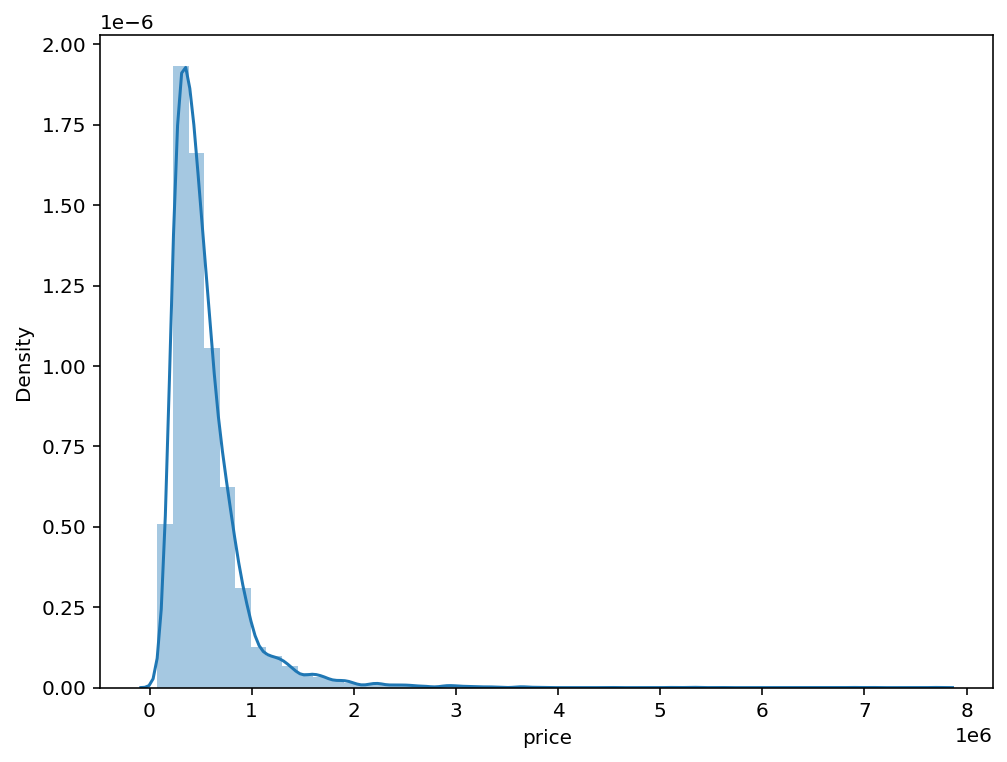

In [12]:
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(data['price'])

In [13]:
data['price'].describe()

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

```
* min = 78,000 
* max = 7,700,000 
* std = 371524.7
```
* price의 경우 min과 max의 차이가 크고, std가 높다. 

### skewness & kurtosis

```
* skewness(왜도)
    normal distribution에서 왜곡 정도를 말하는 것으로, 데이터 분포의 대칭성이 얼마나 결핍되었는지를 측정한다. 완전히 대칭인 분포는 skewness가 0이다. positive skewness는 오른쪽 꼬리가 왼쪽보다 더 길때를 의미하는데, 평균(mean)과 중위수(median)가 mode보다 크다. negative skewness는 왼쪽 꼬리가 오른쪽 보다 더 길 때를 의미하는데, 평균과 중위수가 mode보다 작다.

* kurtosis(첨도)
    첨도는 분포 그래프의 꼬리 부분에 관한 것으로, 분포에 존재하는 특이치(outlier)의 척도이다. kurtosis가 높으면 데이터가 outlier를 가지고 있다는 것을 의미하는 지표이다.
```

In [14]:
#skewness and kurtosis
print("Skewness: %f" % data['price'].skew())
print("Kurtosis: %f" % data['price'].kurt())

Skewness: 4.290252
Kurtosis: 40.154919


* price는 positive skewness로 평균과 중위수가 모드보다 큰 상황이다. 이는 많은 집들이 평균값 이하의 가격에 팔리고 있다는 것을 의미한다. 
* price의 kurtosis 가 굉장히 높은 값을 보인다는 것은 outlier가 많이 존재한다는 것을 의미한다.

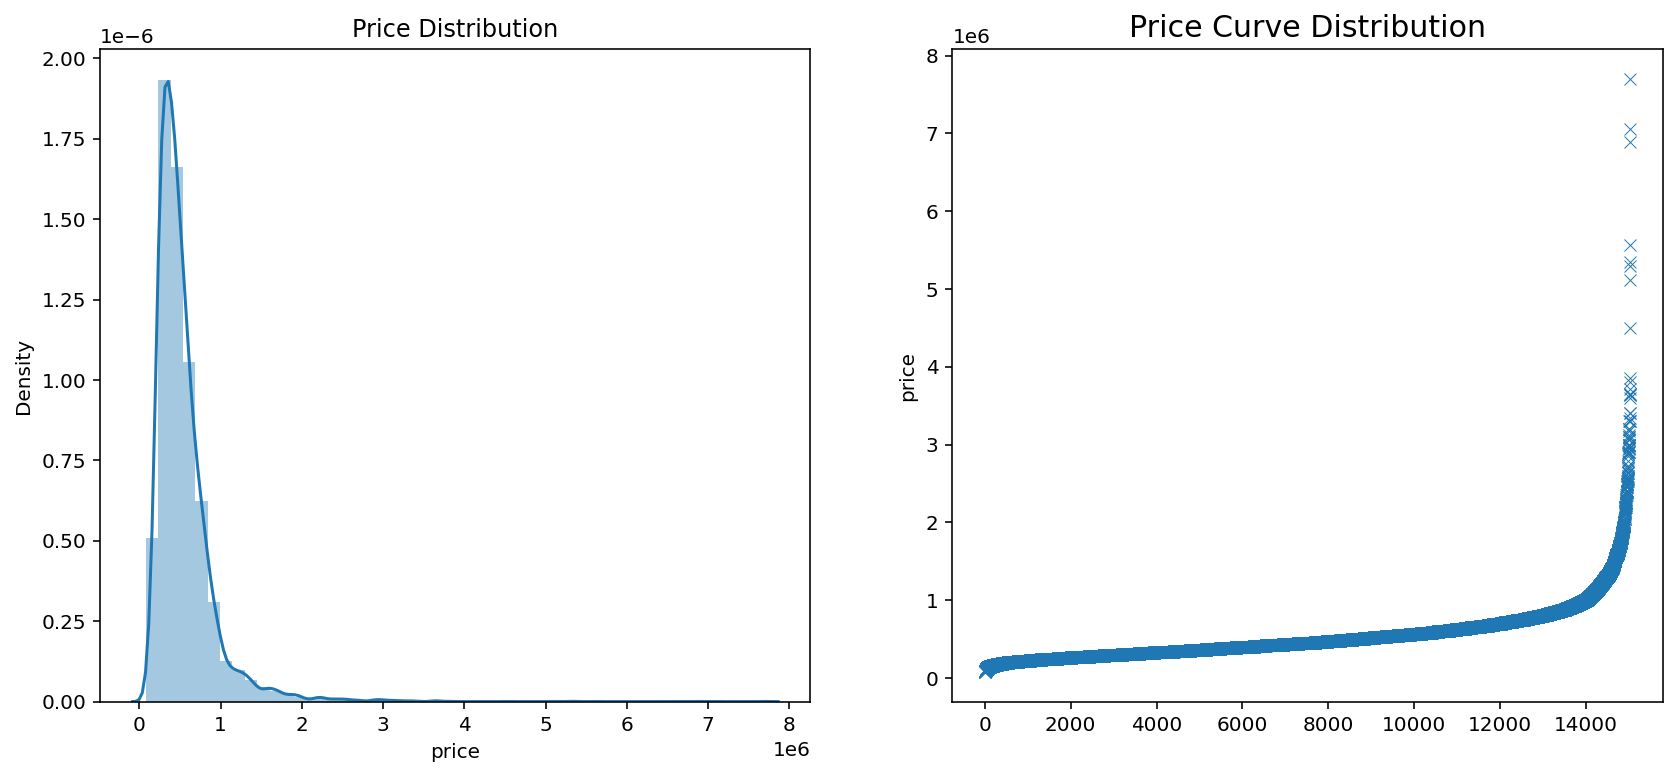

In [15]:
f, ax = plt.subplots(1, 2, figsize = (14, 6))
sns.distplot(data['price'], ax=ax[0])
ax[0].set_title('Price Distribution')
plt.xlim()

sns.scatterplot(range(data.shape[0]), data['price'].sort_values(), ax=ax[1], marker="x")
ax[1].set_title('Price Curve Distribution', fontsize=15)

plt.show()

### Normalize | log-scaling (로그 변환)
로그변환을 통해 치우쳐진 데이터의 분포를 정규분포에 가깝게 만들 수 있다.

<AxesSubplot:xlabel='price', ylabel='Density'>

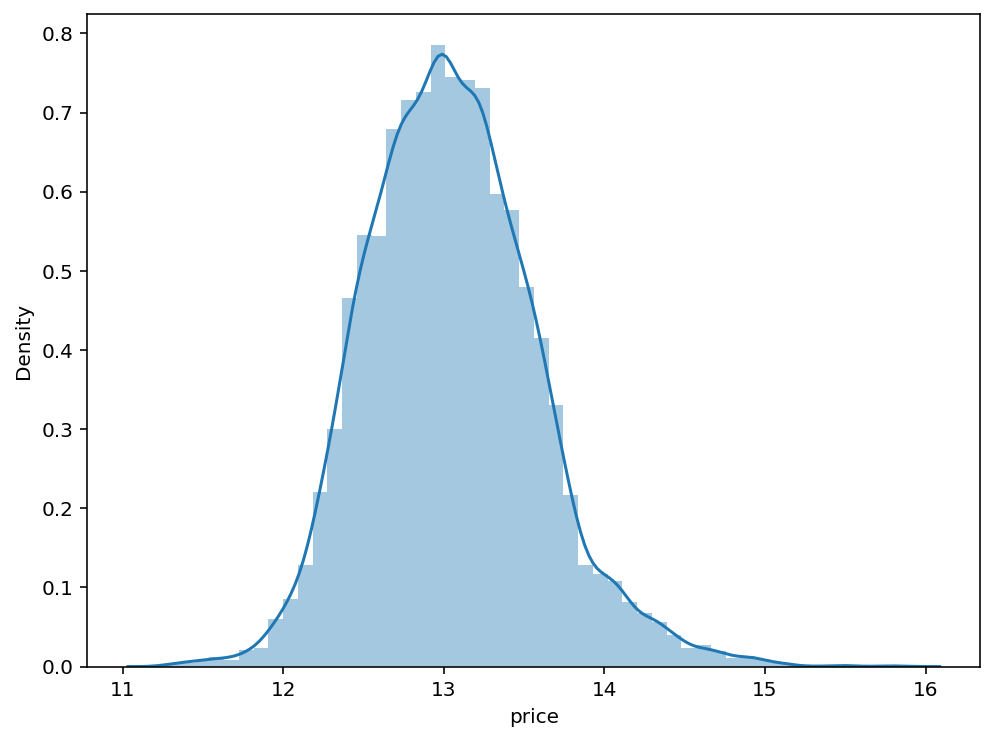

In [16]:
train['price'] = np.log1p(train['price'])
#histogram
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(train['price'])

## 1.3.2 변수 시각화 (feature variables)

### Heatmap
* target variable인 price와 상관관계가 높은 순서대로 feature variables 의 스피어만 순위 상관관계를 보여주는 히트맵이다.

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


<AxesSubplot:>

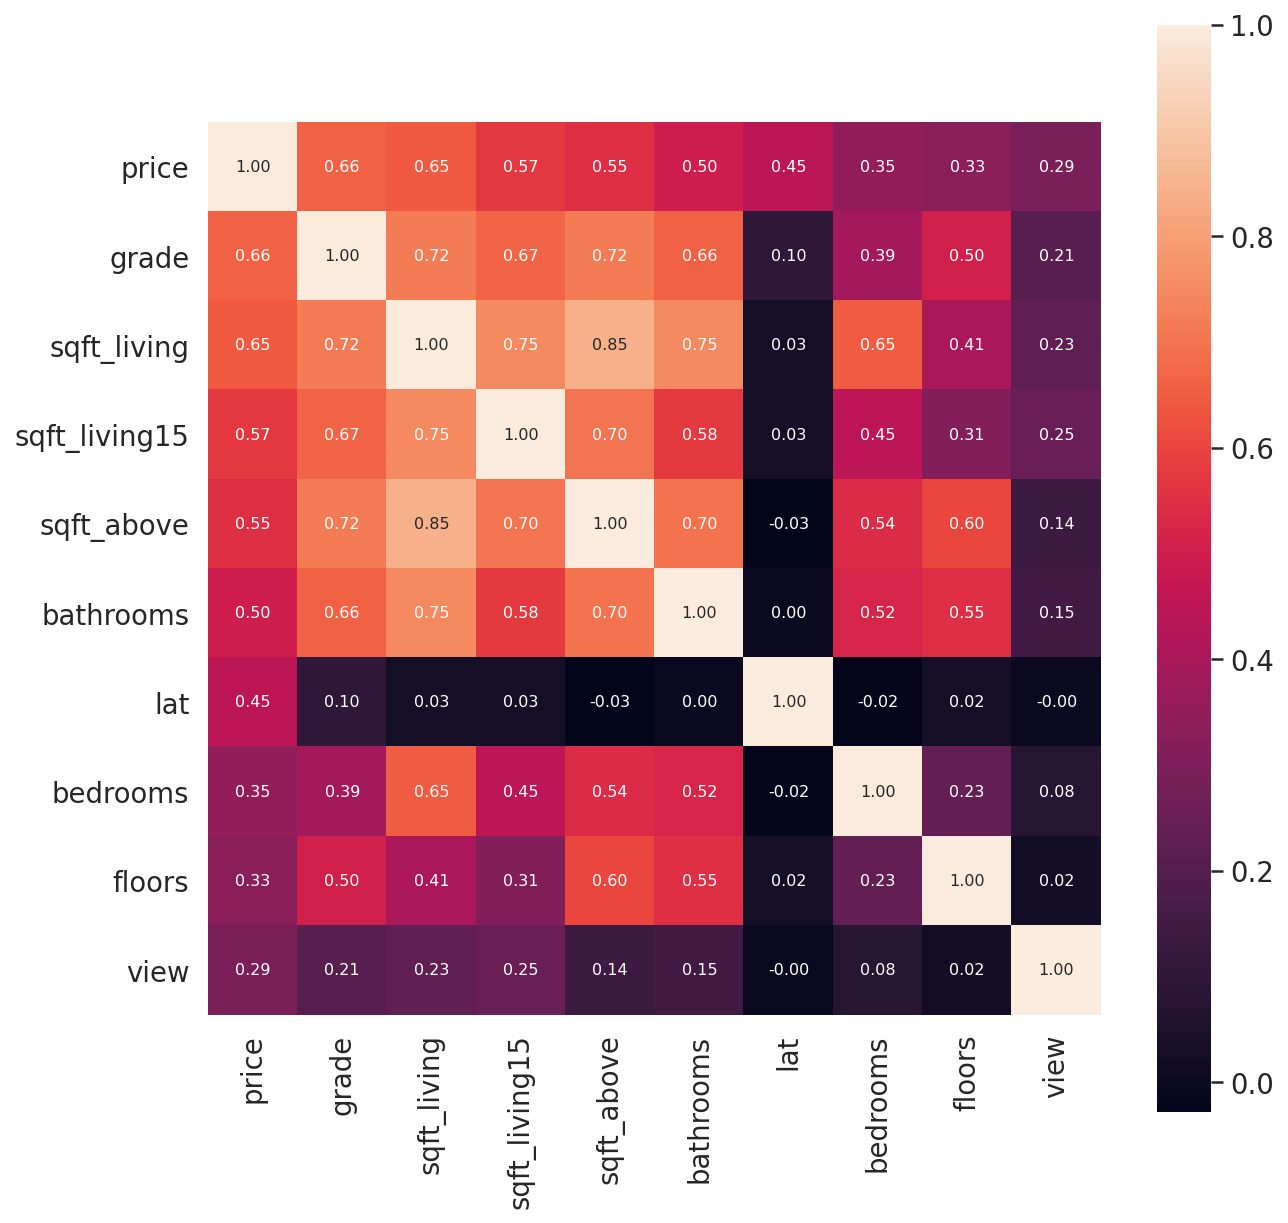

In [17]:
import scipy as sp


cor_abs = abs(train.corr(method='spearman'))
cor_cols = cor_abs.nlargest(n=10, columns='price').index

cor = np.array(sp.stats.spearmanr(train[cor_cols].values))[0]
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

* price와 상관관계가 높은 feature variable 의 순서로는 **grade, sqft_living, sqft_living15, sqft_above, bathrooms** 순이다.

* 앞선 5개의 feature variable 과 price의 상관관계를 자세히 살펴보자

### grade - price
* price 와 상관관계가 가장 높은 feature 변수 grade 와의 상관관계를 시각화 해보자

* grade는 건물 건축 및 디자인의 평가에 따라 최소 1등급부터 최대 13등급까지 구분한 것으로 1-3 등급은 낮은 수준을, 7등급은 평균 수준을, 11-13 등급은 높은 수준을 나타낸다.


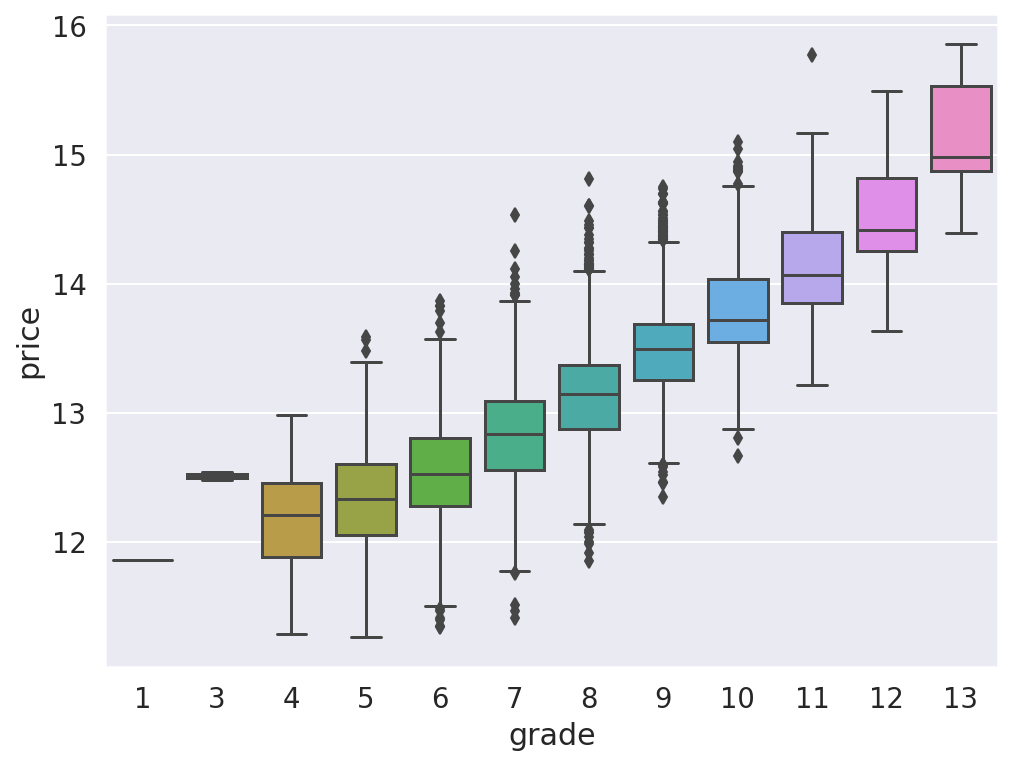

In [18]:
t_data = pd.concat([train['price'], train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=t_data)

* grade-price 는 즉 집의 등급이 높아질수록 가격 상승률이 높아지는 양상을 보인다. 

[유의사항]
* 3등급의 경우엔 낮은 등급에도 불구하고, 비교적 높은 price 를 보인다.
* 3, 7, 8, 11 등급에서 이상치가 보인다.
   

### sqft_living - price

**sqlf_living / sqlf_lot (주거 평방 피트 / 부지 평방 피트)**
* sqlf_living은 주거 평방피트로(1sqlf = 0.0281 평), 실제 사용 면적을 의미함.  
* sqlf_lot은 부지평방 피트로 총 부지의 면적을 의미함.  
* sqlf_living 과 sqlf_lot의 차이는 집앞 마당의 유무, 크기의 차이로 추측할 수 있다. 

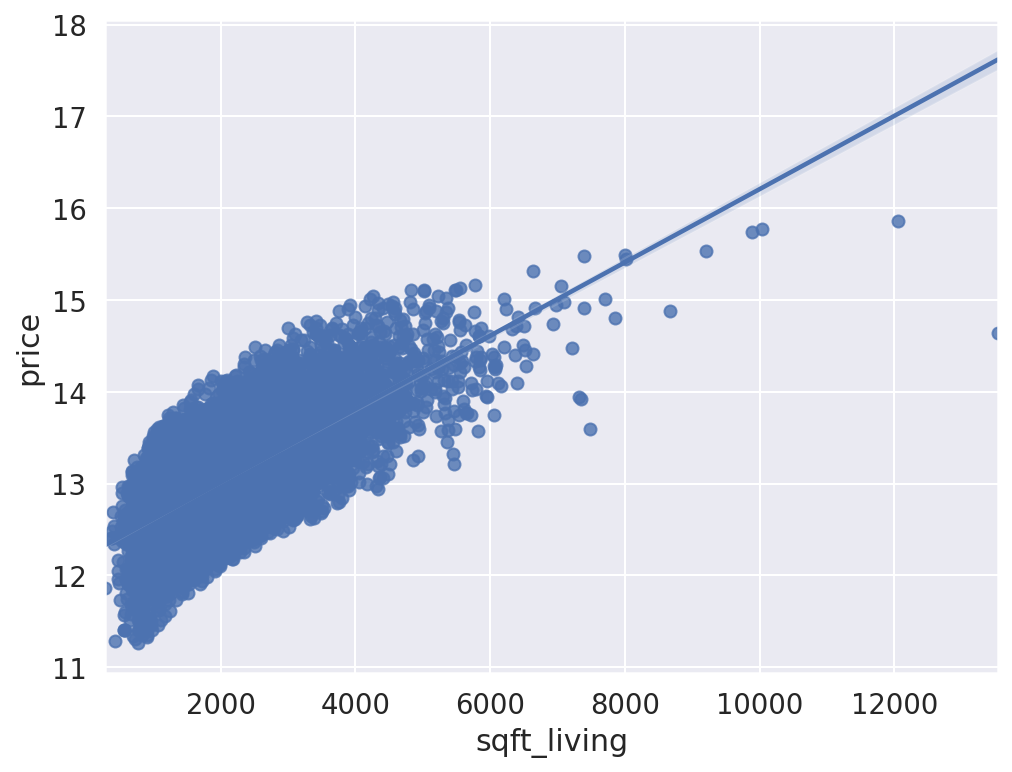

In [19]:
t_data = pd.concat([train['price'], train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=t_data)

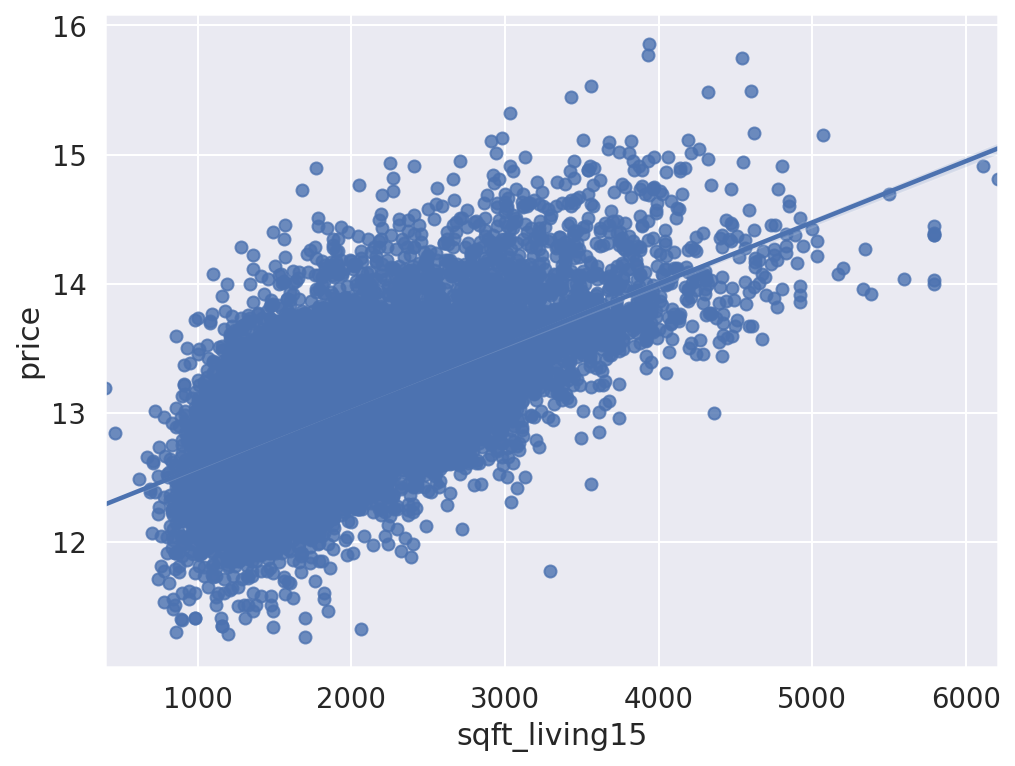

In [20]:
t_data = pd.concat([train['price'], train['sqft_living15']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living15', y="price", data=t_data)

* sqft_living15는 15년도를 기준으로 주거 평방피트를 재조사한 것으로, sqft_living보다 분산이 높아졌다. 
* 이는 재건축으로 인하여 가격의 변동이 발생한 것으로 추측할 수 있다.

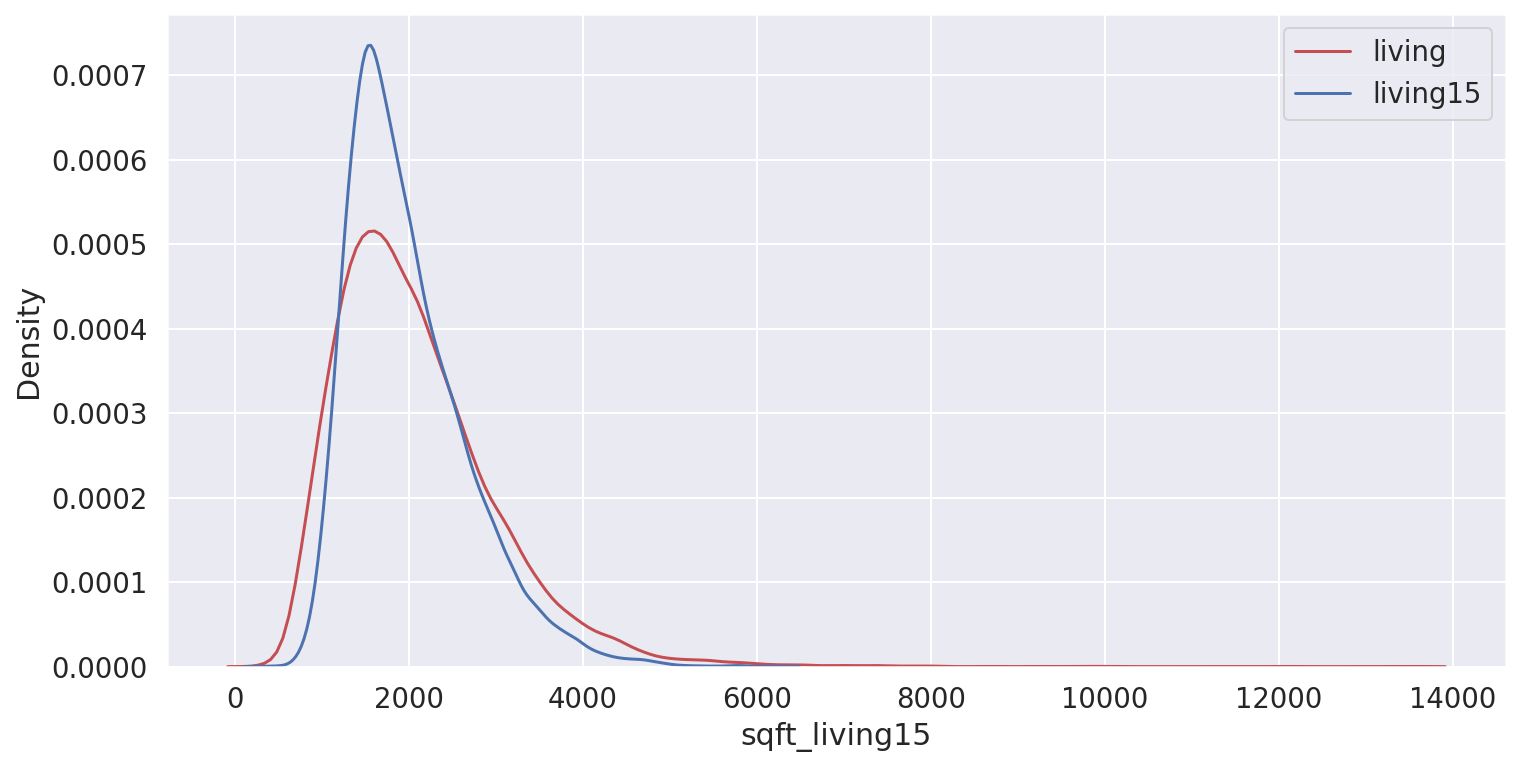

In [21]:
plt.figure(figsize=(12,6))
sns.distplot((data['sqft_living']), hist=False, color='r', label='living')
sns.distplot((data['sqft_living15']), hist=False, color='b', label='living15')
plt.legend()
plt.show()

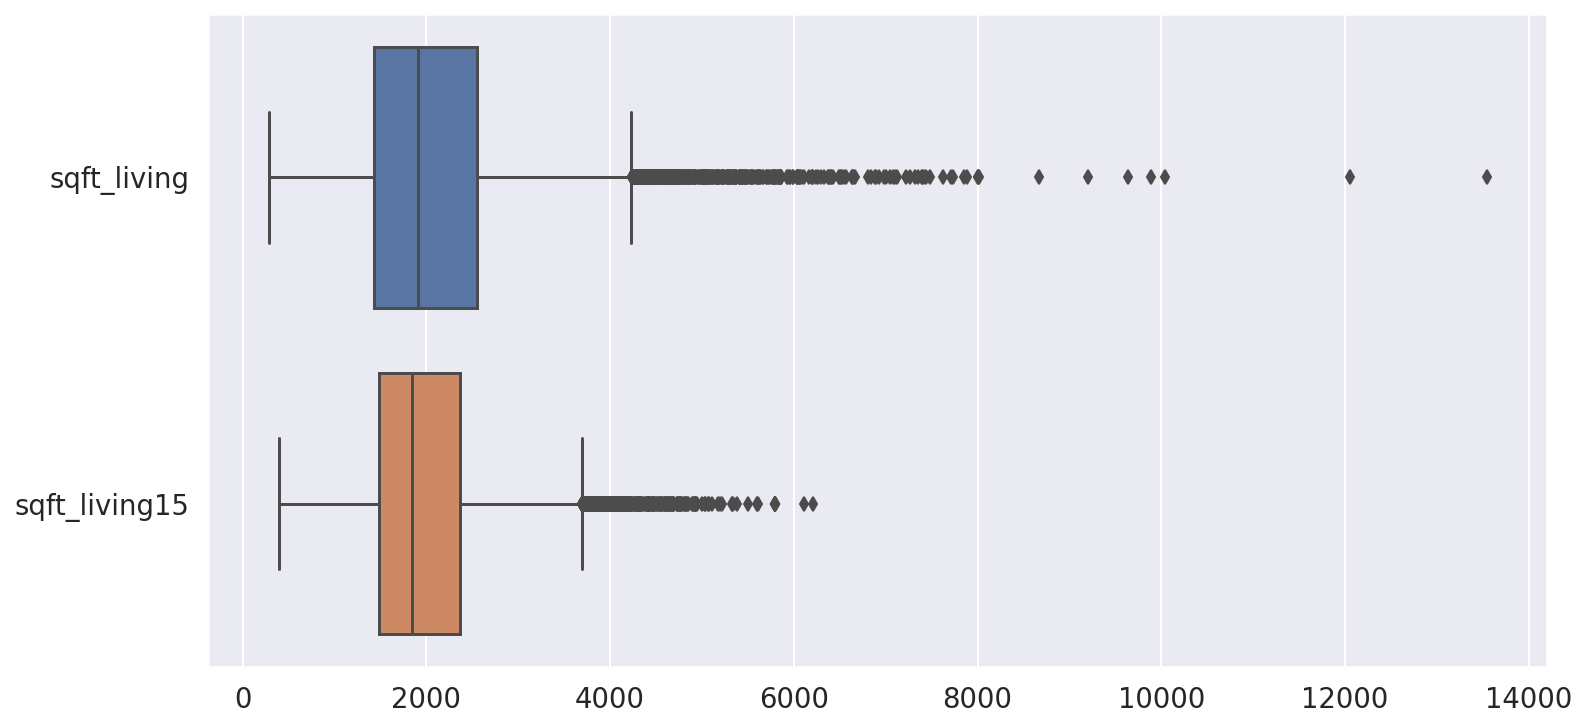

In [22]:
plt.figure(figsize=(12,6))
sns.boxplot(data=data[['sqft_living', 'sqft_living15']], orient='h')
plt.show()

In [23]:
print(data['sqft_living'].count().max())
print(data['sqft_living15'].count().max())

21503
21503


* sqft_living, sqft_living15의 경우, 15000의 값의 빈도가 가장 높은데, living 15가 living에 비해 50% 정도 많이 분포해있다.

### sqft_above - price

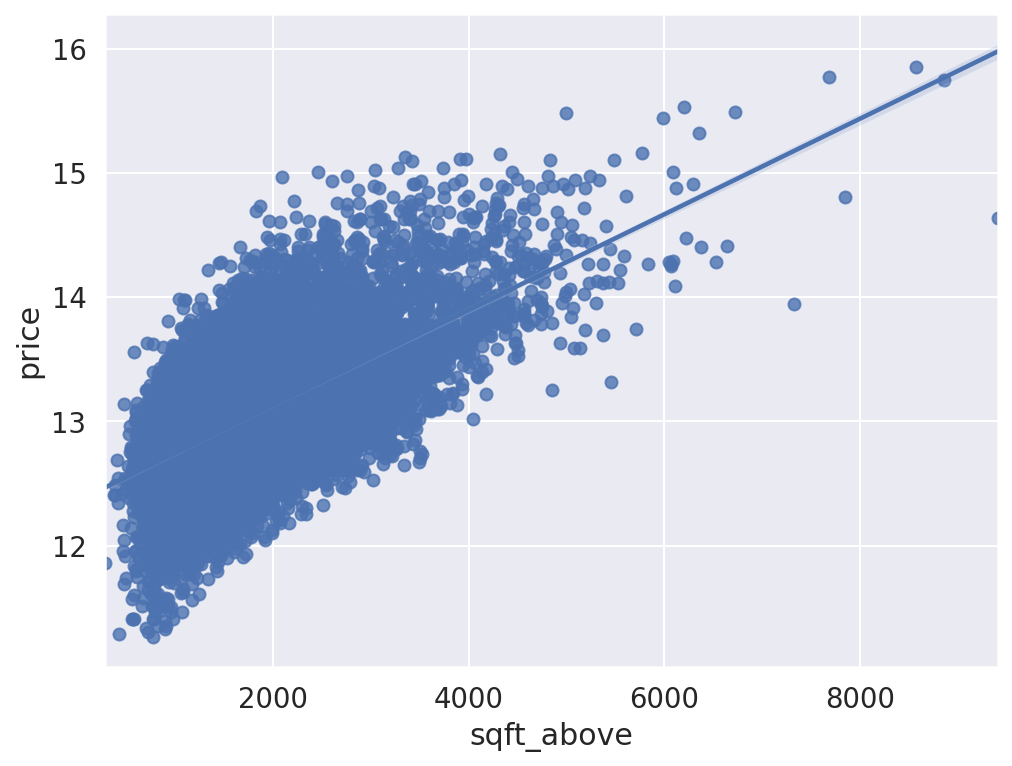

In [24]:
t_data = pd.concat([train['price'], train['sqft_above']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_above', y="price", data=t_data)

### bathrooms - price

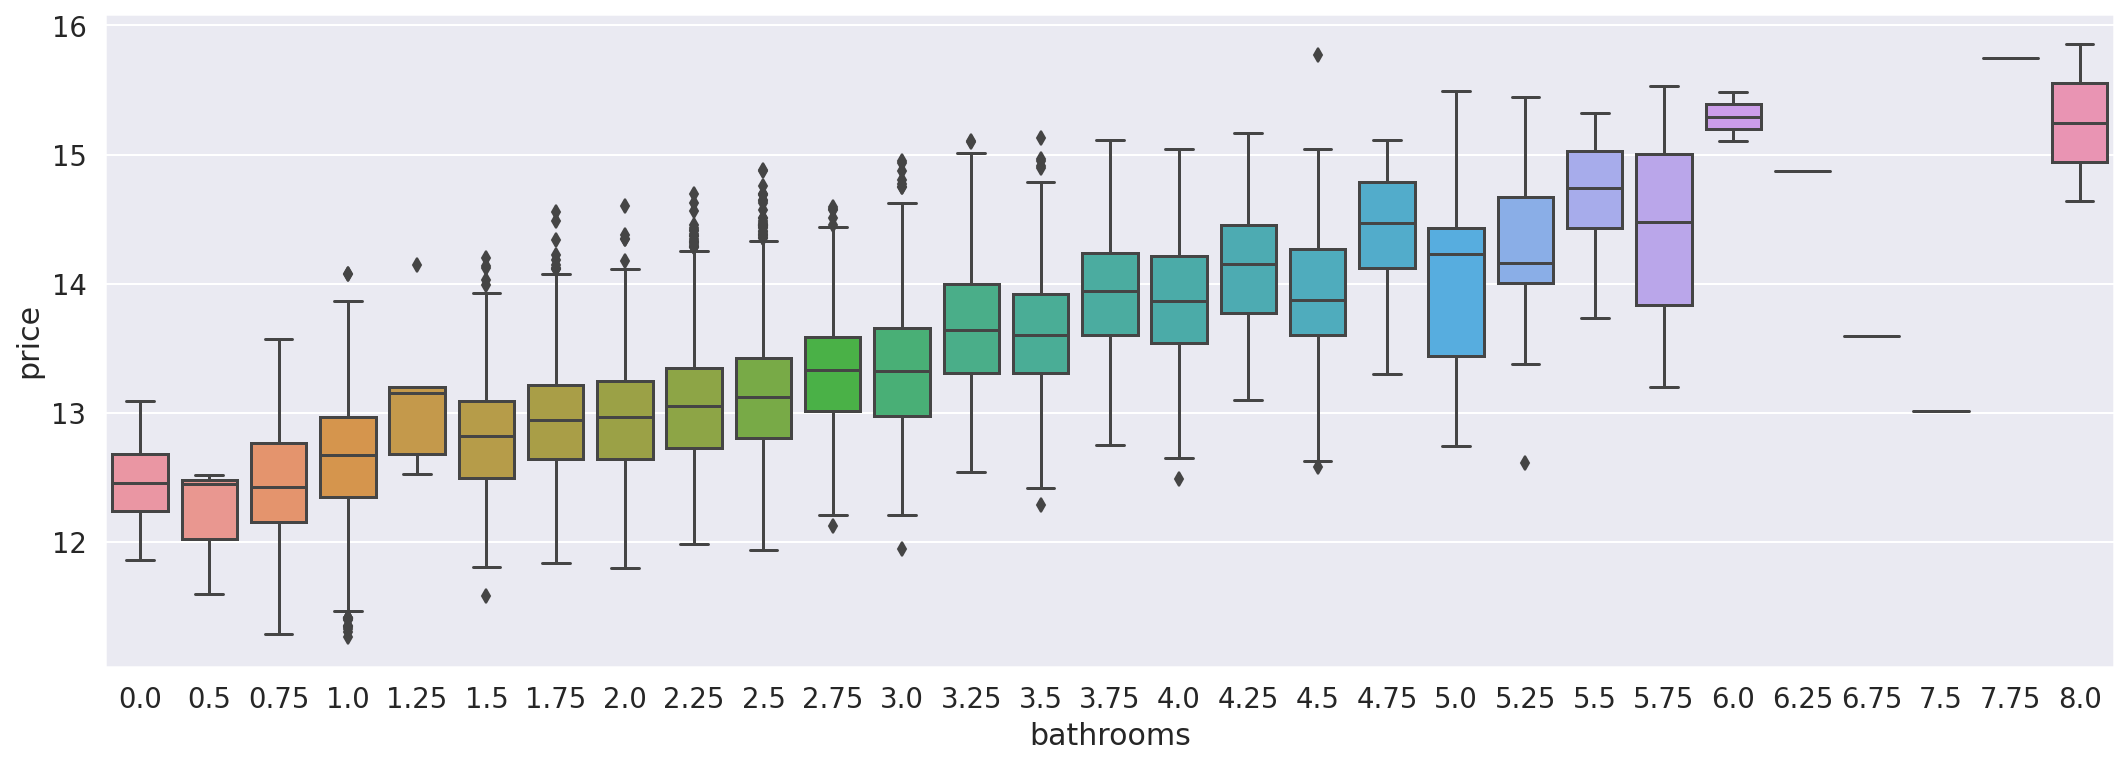

In [25]:
t_data = pd.concat([train['price'], train['bathrooms']], axis=1)
f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x='bathrooms', y="price", data=t_data)

```
* bathrooms 와 price는 유사 선형관계를 가진다.
* bathrooms 의 경우, 각각의 값이 의미하는 것은 아래와 같다. 
    0.5 : 세면대, 화장실
    0.75 : 세면대, 화장실, 샤워실
    1 : 세면대, 화장실, 샤워실, 욕조
    값이 클수록 bathrooms의 옵션과 개수가 늘어나는 것이다.

```

--- 
### Outlier

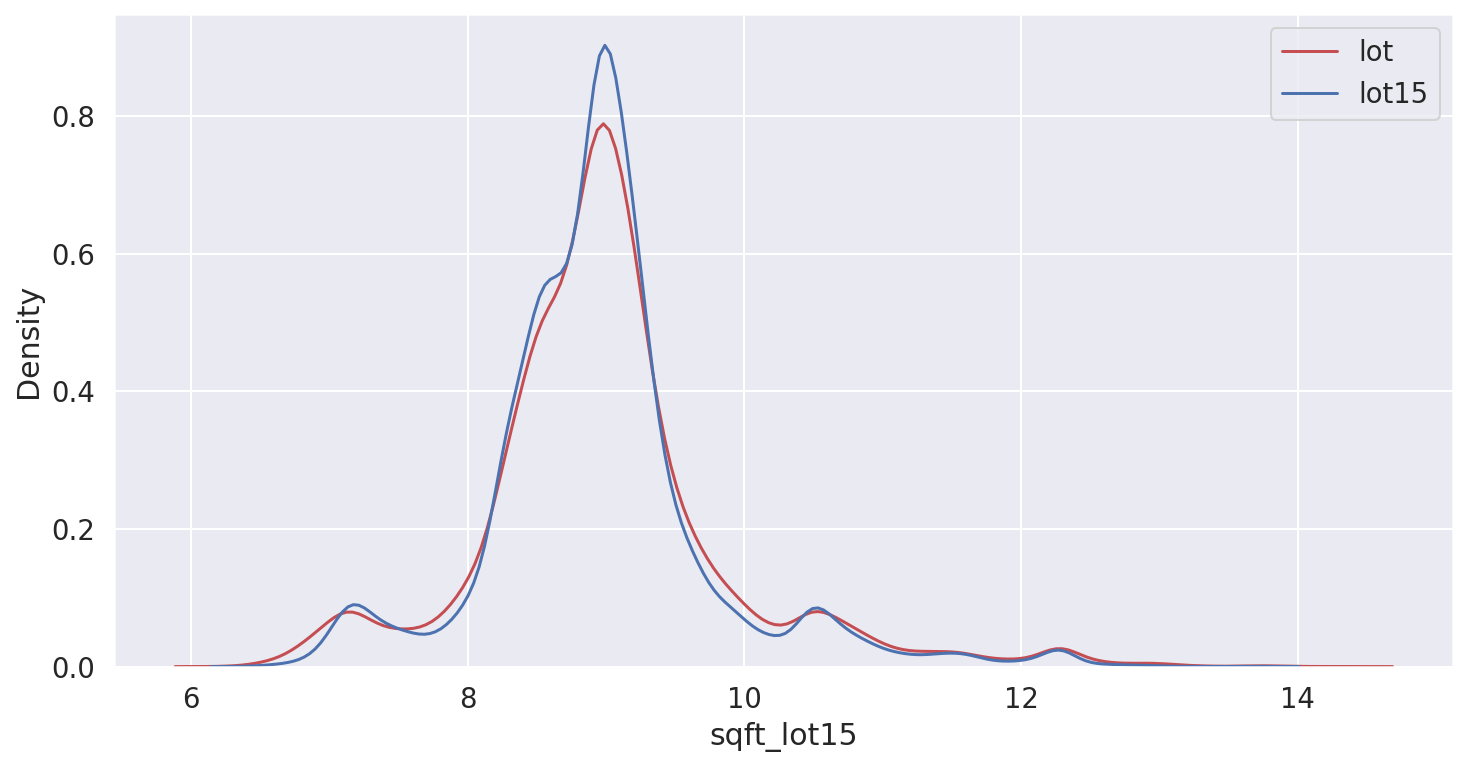

In [26]:
plt.figure(figsize=(12,6))
sns.distplot(np.log(data['sqft_lot']), hist=False, color='r', label='lot')
sns.distplot(np.log(data['sqft_lot15']), hist=False, color='b', label='lot15')
plt.legend()
plt.show()

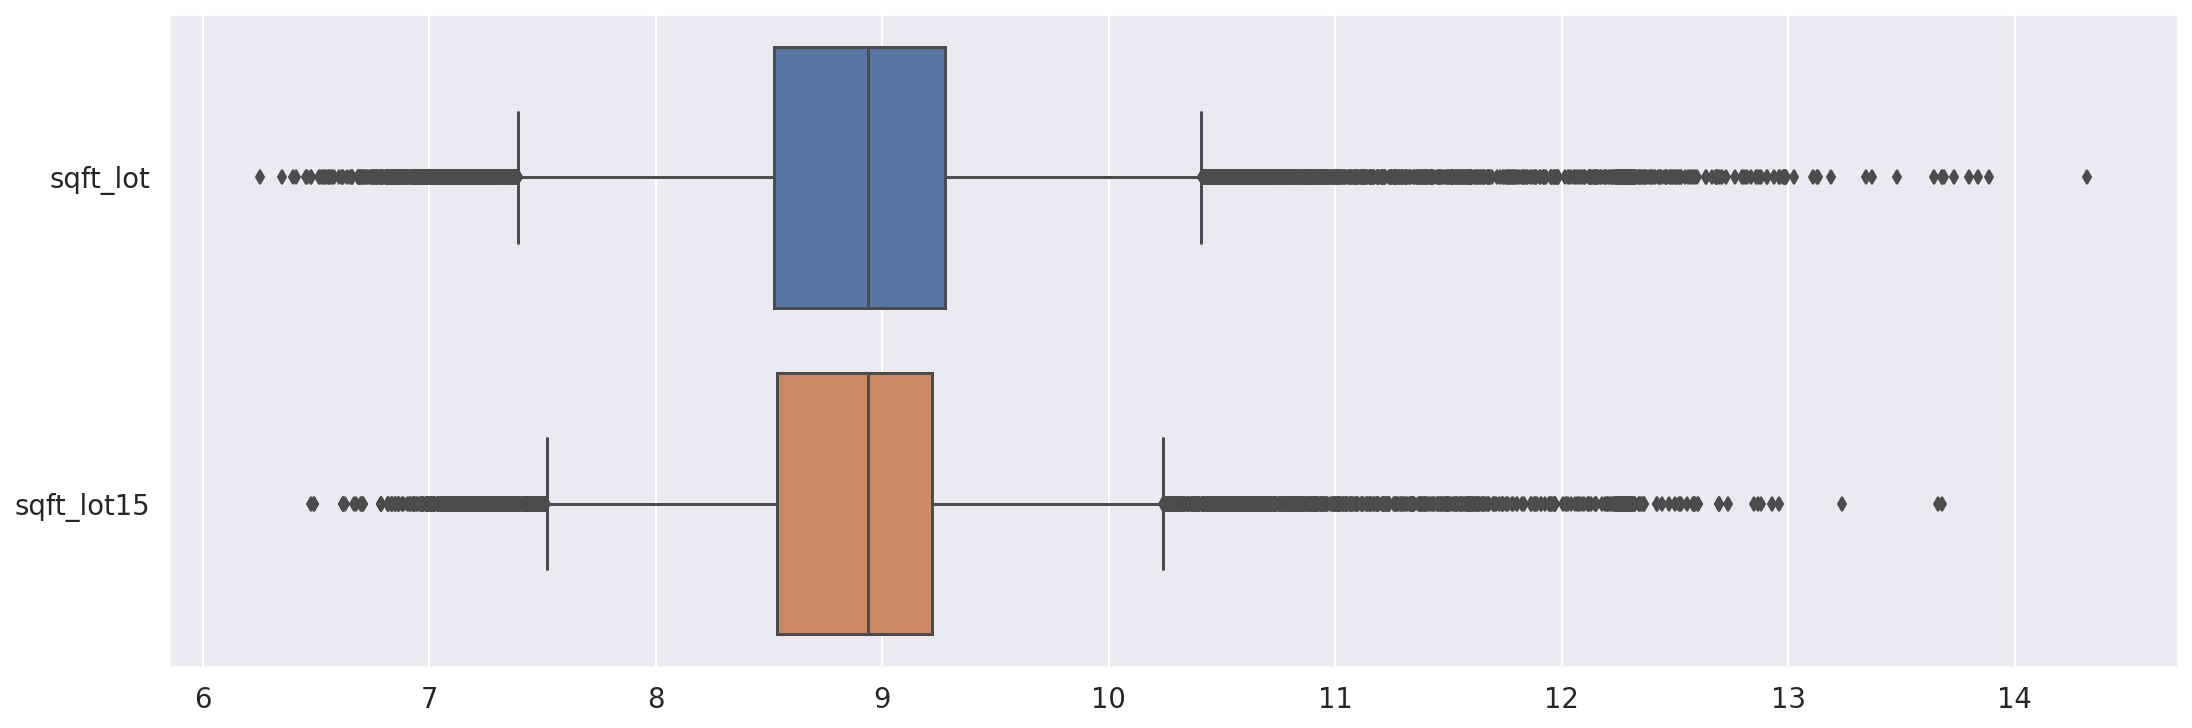

In [27]:
plt.figure(figsize=(18,6))
sns.boxplot(data=np.log(train[['sqft_lot', 'sqft_lot15']]), orient='h')
plt.show()

* sqft_lot, sqft_lot15 feature의 경우 편향이 심하기 때문에 log화 하여 그래프로 나타냈다. 
* 편향이 심하다는 것은 분포를 벗어난 아웃라이어가 많다는 의미이다.

In [28]:
round(data.describe()[['sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15']], 0)

,sqft_living,sqft_living15,sqft_lot,sqft_lot15
count,21503.0,21503.0,21503.0,21503.0
mean,2081.0,1987.0,15117.0,12775.0
std,919.0,686.0,41476.0,27335.0
min,290.0,399.0,520.0,651.0
25%,1430.0,1490.0,5040.0,5100.0
50%,1914.0,1840.0,7616.0,7620.0
75%,2550.0,2370.0,10686.0,10085.0
max,13540.0,6210.0,1651359.0,871200.0


* sqft_living, sqft_lot의 feature Describe를 살펴보면, std 에서 15년도의 feature 값들이 작다.

In [29]:
round(data.describe().loc[['75%', 'max'], ['sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15']], 0)

,sqft_living,sqft_living15,sqft_lot,sqft_lot15
75%,2550.0,2370.0,10686.0,10085.0
max,13540.0,6210.0,1651359.0,871200.0


* max 값을 살펴보면, 큰 아웃라이어가 존재한다는 것을 알 수 있다. 
* 각 feature의 아웃라이어를 FE를 통해 처리할 것이다.

## 1.4 결측치

In [30]:
data.isnull().sum()

id                  0
date                0
price            6468
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront          0
view                0
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated        0
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

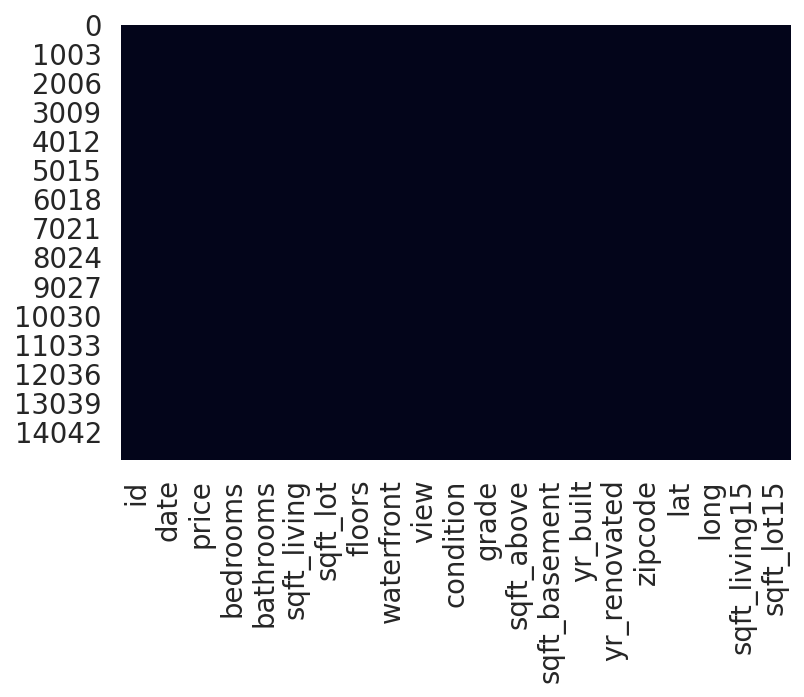

In [31]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

sns.heatmap(train.isnull(), cbar=False)
plt.show()

<AxesSubplot:>

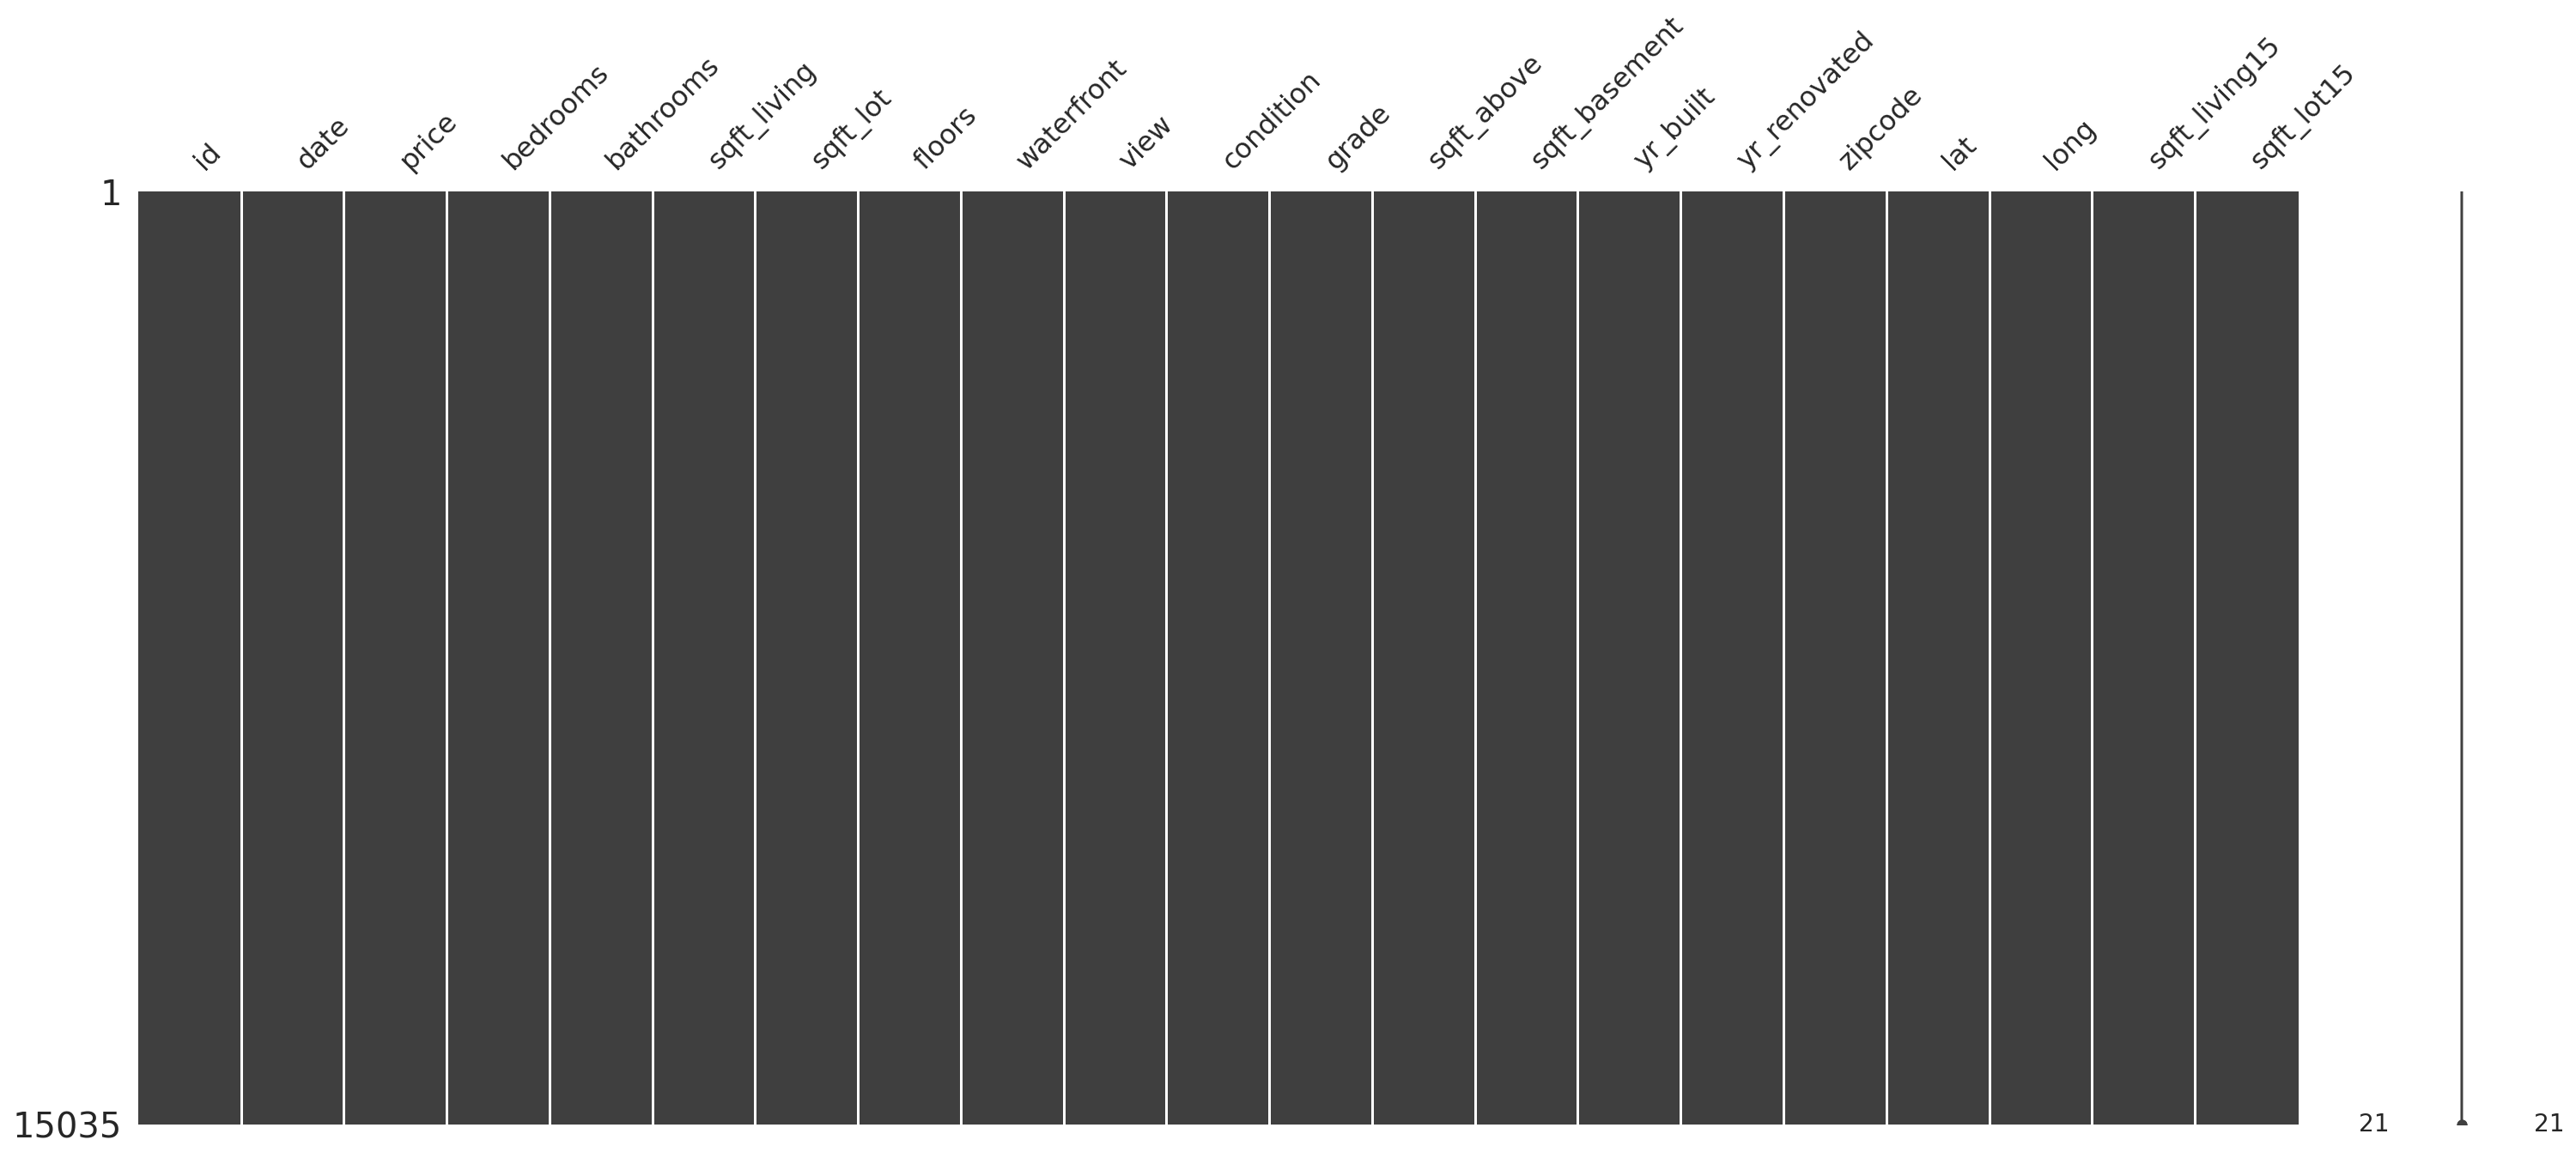

In [32]:
msno.matrix(train)

* 결측치는 없는 상황이다 !!

# 2. 피처 엔지니어링
## 2.1 이상치 제거

앞서 taget 변수인 price와 높은 상관관계를 가진 변수들을 탐색하면서 
**grade, sqft_living, sqft_lot** 에서 이상치를 발견했다.

### 2.1.1 sqft_living

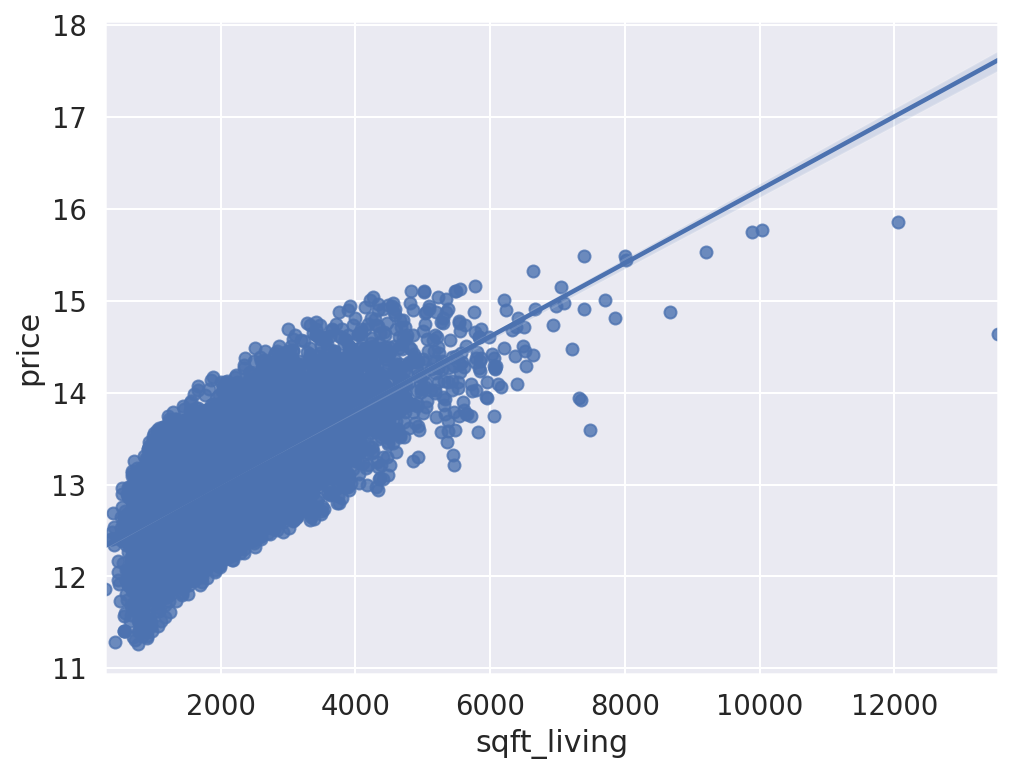

In [33]:
t_data = pd.concat([train['price'], train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=t_data)

In [34]:
train.loc[train['sqft_living'] > 13000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,8912,20140505T000000,14.639686,7,8.0,13540,307752,3.0,0,4,...,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


* 다른 값들에 비해 sqft_living 의 값이 비정상적으로 높은 이상치를 제거한다.

In [35]:
train = train.loc[train['id']!=8912]

### 2.1.2 grade

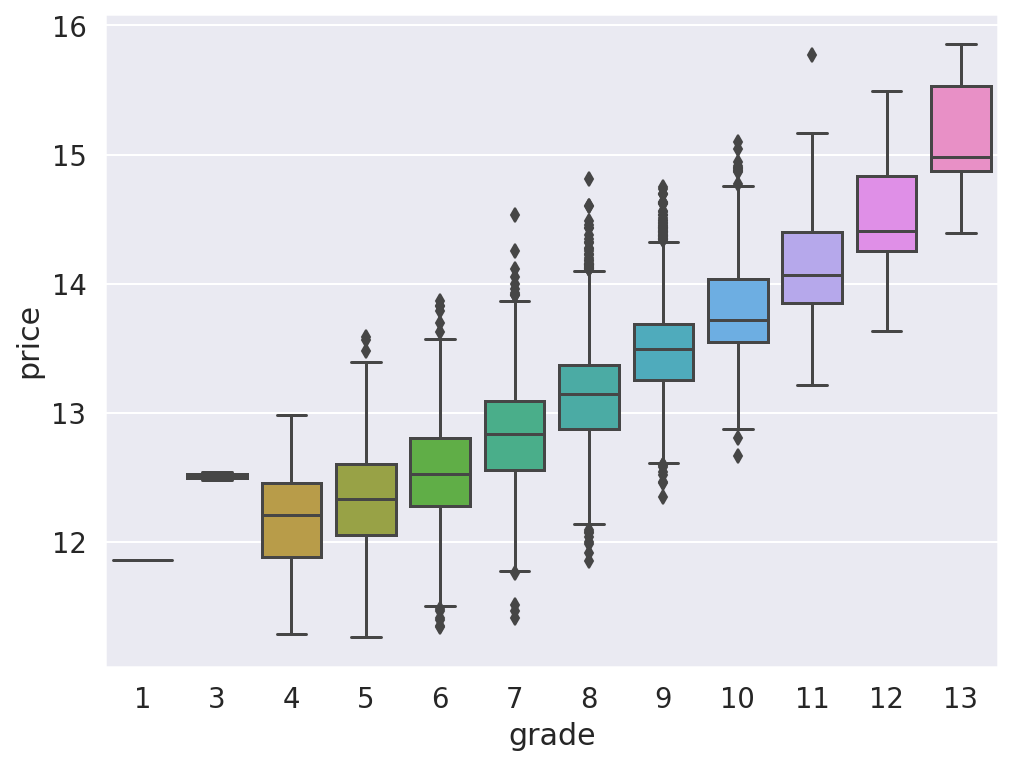

In [36]:
t_data = pd.concat([train['price'], train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=t_data)

In [37]:
train.loc[(train['price']>12) & (train['grade'] == 3)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2302,2302,20150225T000000,12.476104,1,0.75,520,12981,1.0,0,0,...,3,520,0,1920,0,98022,47.2082,-121.995,1340,12233
4123,4123,20141104T000000,12.542548,1,0.00,600,24501,1.0,0,0,...,3,600,0,1950,0,98045,47.5316,-121.749,990,22549


* grade, sqft_ 모두 낮기 때문에, 위 두 값을 모두 이상치로 볼 수 있다.

In [38]:
train.loc[(train['price']>14.5) & (train['grade'] == 7)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
12346,12346,20150115T000000,14.533351,4,3.25,3580,19989,1.5,1,4,...,7,3480,100,1915,1965,98125,47.7087,-122.276,2410,6389


In [39]:
train.loc[(train['price']>14.7) & (train['grade'] == 8)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7173,7173,20140813T000000,14.808763,5,4.0,4230,27295,2.0,1,4,...,8,3230,1000,1949,1985,98033,47.6803,-122.214,2660,27295


In [40]:
train.loc[(train['price']>15.6) & (train['grade'] == 11)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,20140611T000000,15.77031,5,4.5,10040,37325,2.0,1,2,...,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449


* 위의 5개의 값은 특별한 이유 없이 가격이 높아 보이므로 이상치로 규정하여 제거한다

In [41]:
train = train.loc[train['id']!=2302]
train = train.loc[train['id']!=4123]
train = train.loc[train['id']!=12346]
train = train.loc[train['id']!=7173]
train = train.loc[train['id']!=2775]

## 2.2 변수 정리


### date
* date 를 우리가 필요한 YYYY-mm-dd 의 형태로 변환한다.
* date를 정수형 데이터로 처리함으로써, date를 예측을 위한 특성으로 활용할 수 있다.

In [42]:
train['date'] = train['date'].apply(lambda i: i[:8]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013,12.309987,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225,12.100718,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218,13.142168,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627,12.458779,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115,12.583999,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [43]:
test['date'] = test['date'].apply(lambda i: i[:8]).astype(int)
test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


### id
* id 컬럼은 데이터 예측에 필요가 없으므로 삭제한다. 

In [44]:
del train['id']

print(train.columns)

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [45]:
del test['id']
print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


### normalization

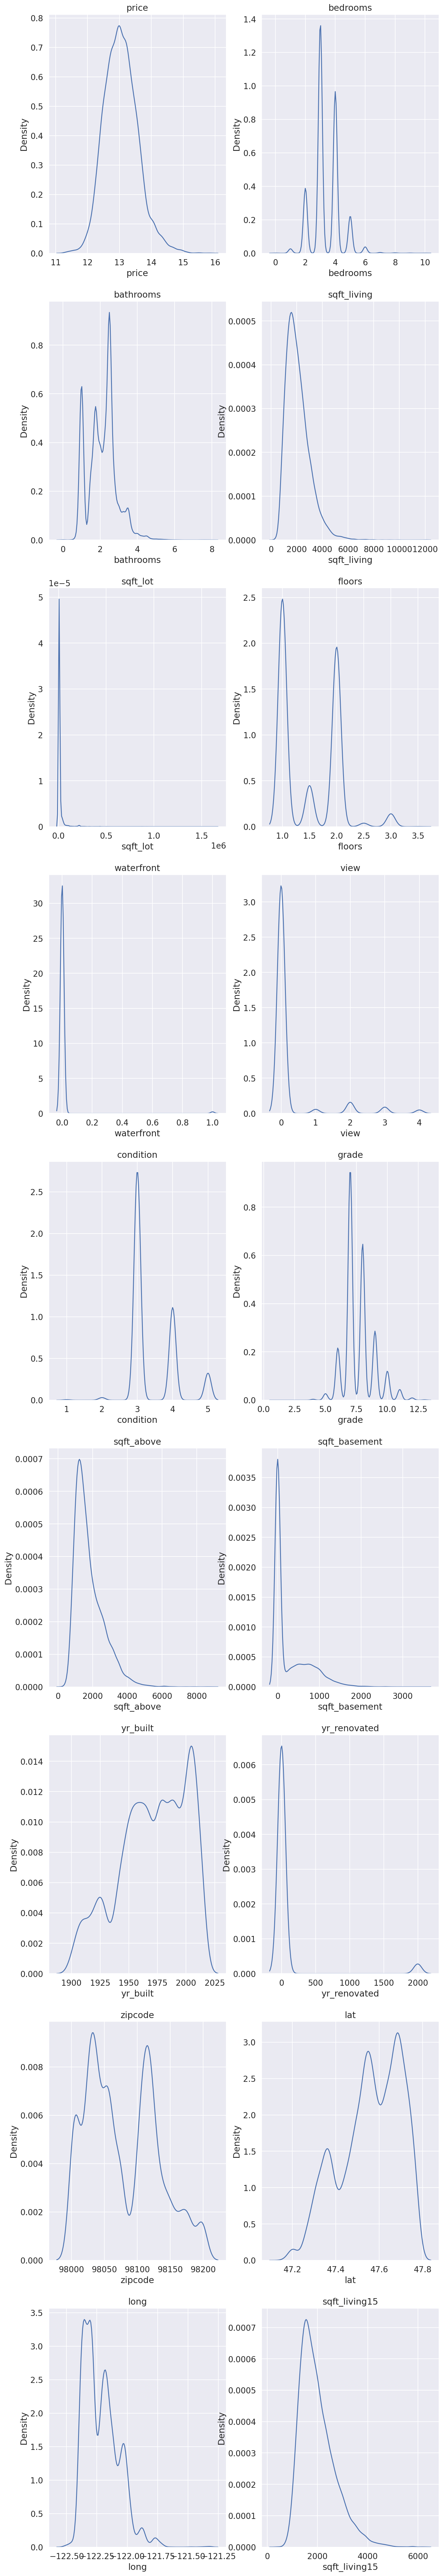

In [46]:
fig, ax = plt.subplots(9, 2, figsize=(12, 80))

count = 1
columns = train.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

In [47]:
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement' ]

for c in skew_columns:
    train[c] = np.log1p(train[c].values)
    train[c] = np.log1p(train[c].values)

### 학습 데이터에서 라벨 제거
price 컬럼을 따로 y라는 변수에 저장한 후 해당 컬럼은 지워준다.

In [48]:
y = train['price']
del train['price']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


## 3. Model Tuning

### 1) RMSE

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [50]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [51]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [52]:
random_state=2021

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [53]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'GradientBoostingRegressor': 165622.75018741103,
 'XGBRegressor': 145182.3386055391,
 'LGBMRegressor': 144509.66842075097,
 'RandomForestRegressor': 154094.92007160292}

In [54]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df
    
get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,165622.750187
RandomForestRegressor,154094.920072
XGBRegressor,145182.338606
LGBMRegressor,144509.668421


### 2) Grid Search


In [55]:
from sklearn.model_selection import GridSearchCV

In [59]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
   
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [60]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10, 20],
    'learning_rate': [0.05, 0.1],
    'boosting_type': ['gbdt', 'rf', 'dart', 'goss']
}

In [61]:

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    2.8s
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:   15.1s finished


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,boosting_type,learning_rate,max_depth,n_estimators,score,RMSLE
9,gbdt,0.10,10,100,-0.026839,0.163827
11,gbdt,0.10,20,100,-0.026878,0.163945
47,goss,0.10,20,100,-0.027022,0.164384
45,goss,0.10,10,100,-0.027372,0.165444
39,goss,0.05,10,100,-0.028384,0.168475
41,goss,0.05,20,100,-0.028482,0.168766
46,goss,0.10,20,50,-0.028787,0.169669
5,gbdt,0.05,20,100,-0.028866,0.169899
10,gbdt,0.10,20,50,-0.028963,0.170185
44,goss,0.10,10,50,-0.028990,0.170263


In [62]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [63]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.1638')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.1638.csv saved!


캐글 제출 스코어는 503779.33334 입니다... ㅜ_ㅜ